# News Sentiment Analysis

## Import Libraries

In [1]:
# // TODO: TINGS
#     ✓ Find API for data collection
#     ✓ Data Gathering
#     ✓ Data Cleaning
#     - Feature generation
#     - Feature Engineering/selection
#     - Model Train
#     - Model Test
#     - Model Evaluation

In [2]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re
from IPython.display import clear_output
import time
import random

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch

# Add the path to the API Scraper
## Project Path
project_path = "../"

## Add the path to API Scraper
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

# Custom News Libraries
from scraper import get_cached_news_metadata, extract_text_from_url

# Text preprocessing
from preprocessor import clean_text

## Fetch Data

In [3]:
def scrape_data(n_request: int = 10, before_date: str = "2025-12", path: str = ".", last_idx:int = 0) -> pd.DataFrame:
    
    articles = []

    for i in tqdm(range(last_idx, last_idx + n_request), desc="Fetching News Data...", unit="news"):
        metadata = get_cached_news_metadata(page=i, before_date=before_date, path=path)

        data_list = metadata.get("data", [])

        for article in data_list:
            # extract sentiment (first entity if exists)
            entities = article.get("entities", [])
            if entities and "sentiment_score" in entities[0]:
                sentiment = entities[0]["sentiment_score"]
            else:
                sentiment = None

            # store sentiment as its own field inside article
            article["sentiment"] = sentiment

            articles.append(article)

    # final dataframe
    return pd.DataFrame(articles)

### Caching

In [4]:
# Arguments for the caching function
before_date = "2025-11"

data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(data_path, f"{before_date}_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_cached_links = True

# get the last index of the file 
json_files = os.path.join(project_path, f"news_cache/{before_date}/json/page-*.json")
list_of_files = glob.glob(json_files)

## Extract page numbers set to True if you want to get new api request.
get_new_requests = False

if get_new_requests:
    page_nums = []
    for f in list_of_files:
        match = re.search(r"page-(\d+)\.json$", os.path.basename(f))
        if match:
            page_nums.append(int(match.group(1)))

    last_idx = max(page_nums)
    n_requests = 101 # marketaux api limit (last index is excluded)

else:
    last_idx = 0
    n_requests = len(list_of_files) #number of pages we cached to be processed

In [5]:
# filling missing text data function

def safe_extract(row):
    try:
        text = extract_text_from_url(row["url"])
        # print(f"{row['title']} {row['description']}")
        return text

    except Exception as e:
        tqdm.write(f"failed to extract from url \n Err: {e} \n appending title and description")
        time.sleep(2)
        print(f"{row['title']} {row['description']}")
        clear_output(wait=True)
        text = f"{row['title']} {row['description']}"
        return text

In [6]:
# tqdm for cleaner output
tqdm.pandas(desc="Extracting News from URL's", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not overwrite_cached_links:
    print("Loading cached dataset...")
    news_df = pd.read_csv(cached_file, sep = ',')
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and overwrite_cached_links:
    print("Overwriting old data and caching new data...")
    # Scrape the data
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    
    # Extract text from the news
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Finished Caching")

Extracting News from URL's:  46%|████▋     | 6367/13695 [1:57:54<2:15:42,  1.11s/news] 


KeyboardInterrupt: 

### Fetch the Text from URL

## EDA

### View the Data

In [ ]:
news_df.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text
0,835afa5b-de30-4bba-b781-2ad1cb0f21ca,United Airlines’ Leaked Debit Card: What We Kn...,United Airlines is reportedly planning to laun...,,Just weeks after Southwest Airlines announced ...,https://upgradedpoints.com/news/united-airline...,https://upgradedpoints.com/wp-content/uploads/...,en,2025-10-17T14:20:59.000000Z,upgradedpoints.com,None,"[{'symbol': 'SOFI', 'name': 'SoFi Technologies...",[],0.80740,Just weeks after Southwest Airlines announced ...
1,2ccba025-54fa-45c5-a5e1-fd6d0c7672e9,Stride vs. Coursera: Which Online Learning Sto...,"Which edtech player, LRN with its surging enro...","stock, stocks, investment, investment advice, ...","This page has not been authorized, sponsored, ...",https://www.zacks.com/stock/news/2771244/strid...,https://staticx-tuner.zacks.com/images/article...,en,2025-10-17T14:20:00.000000Z,zacks.com,None,"[{'symbol': 'LRN', 'name': 'Stride, Inc.', 'ex...",[{'uuid': '86bfcea4-e107-4558-bde8-d67a199d8f6...,0.44040,Pardon Our Interruption\n\nAs you were browsin...
2,0b6d816a-8cc4-4e13-94fe-0181b84b24fe,Coal block allocation letter constitutes 'prop...,The Delhi High Court has ruled that a coal blo...,"Delhi High Court, coal block allocation letter...",Live Events\n\n\n\nas a Reliable and Trusted N...,https://economictimes.indiatimes.com/industry/...,"https://img.etimg.com/thumb/msid-124633654,wid...",en,2025-10-17T14:19:41.000000Z,economictimes.indiatimes.com,None,"[{'symbol': 'PRAKASH.NS', 'name': 'Prakash Ind...",[],0.52920,Synopsis\n\nThe Delhi High Court has ruled tha...
3,5e939c49-0ba1-4e51-939c-f71b03ec1cf4,Will Chubb Limited Pull Off a Surprise This Ea...,CB's Q3 results are likely to reflect broad-ba...,"stock, stocks, investment, investment advice, ...",We use cookies to understand how you use our s...,https://www.zacks.com/stock/news/2771203/will-...,https://staticx-tuner.zacks.com/images/article...,en,2025-10-17T14:19:00.000000Z,zacks.com,None,"[{'symbol': 'CB', 'name': 'Chubb Limited', 'ex...",[],0.27320,Pardon Our Interruption\n\nAs you were browsin...
4,76aad858-6291-4391-9927-9475a8b9e92d,Bank Nifty hits a fresh all-time high as Sense...,"Indian equities close week on high note, with ...","Bank Nifty, Sensex, foreign institutional inve...","Markets closed on a strong note on Friday, wit...",https://www.thehindubusinessline.com/markets/b...,https://bl-i.thgim.com/public/incoming/a7unxi/...,en,2025-10-17T14:18:53.000000Z,thehindubusinessline.com,None,"[{'symbol': '^CRSMID', 'name': 'NIFTY Midcap 1...",[],0.83600,"Markets closed on a strong note on Friday, wit..."
5,4a4af871-3865-43a3-9785-681d8b81b265,Demand for baby-care products growing in doubl...,GST rate cuts are significantly boosting deman...,"baby care products demand, Chicco baby product...",Live Events\n\n\n\nas a Reliable and Trusted N...,https://economictimes.indiatimes.com/industry/...,"https://img.etimg.com/thumb/msid-124633548,wid...",en,2025-10-17T14:18:02.000000Z,economictimes.indiatimes.com,None,"[{'symbol': 'JNJ', 'name': 'Johnson & Johnson'...",[],0.67400,Synopsis\n\nGST rate cuts are significantly bo...
6,d6972536-ea27-493e-8a55-6cc4897281f5,Rare Indian Shares ( by Ashwani K Aggarwal ): ...,Dalmia Bharat Sugar Demerger date 31/10/2025 ...,,14 Years Old With 15000 Posts in Archives THE ...,http://www.rareindianshares.info/2025/10/dalmi...,http://www.rareindianshares.info/favicon.ico,en,2025-10-17T14:17:00.000000Z,rareindianshares.info,None,"[{'symbol': 'BSE.NS', 'name': 'BSE Limited', '...",[],-0.15310,14 Years Old With 15000 Posts in Archives THE ...
7,764eb3d4-48b7-4ee3-9d9b-c98433b88fb2,"Chamber of Commerce Sues Over Trump’s $100,000...",The nation's largest business lobbying group s...,,The nation’s largest business lobbying group s...,https://www.insurancejournal.com/news/national...,https://www.insurancejournal.com/app/uploads/2...,en,2025-10-17T14:15:28.000000Z,insurancejournal.

### Check for Missing Values

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0


### Distribution of the Sentiment Scores

#### Plotting Functions

In [ ]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Data Plots (Before Cleaning)

##### Sentiment Score Distribution

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

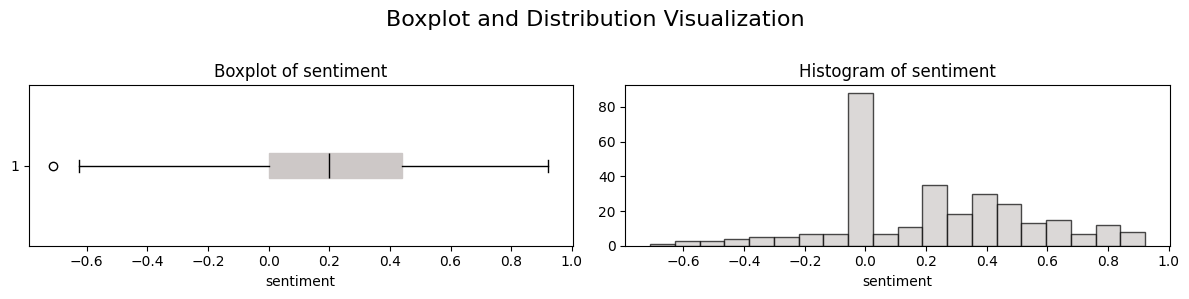

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

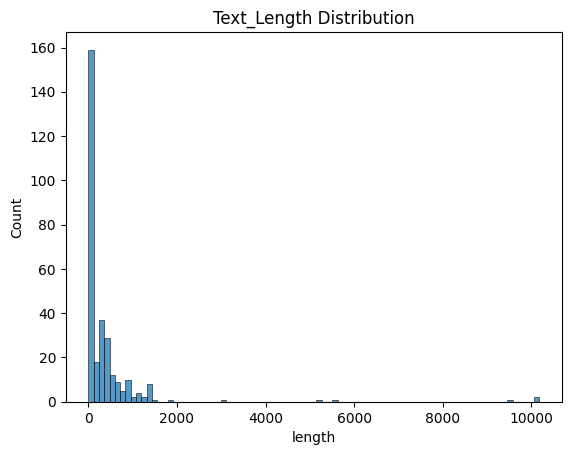

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count      303.000000
mean       413.554455
std       1113.014957
min          0.000000
25%          4.000000
50%         89.000000
75%        408.000000
max      10178.000000
Name: length, dtype: float64

## Data Cleaning

### Fix Missing Values

In [ ]:
news_df["text"] = news_df["text"].replace("", None)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                   0            0.000000
keywords                      0            0.000000
snippet                       0            0.000000
url                           0            0.000000
image_url                     0            0.000000
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score             303          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                         76           25.082508
length                        0            0.000000


In [ ]:
news_df["description"] = news_df["description"].fillna('')

#Fill the missing text from the url with just the news description. due to the scraper is unable to get the html since the site requires authorization
news_df["text"] = news_df["text"].fillna(
    news_df["title"].fillna('') + " " + news_df["description"].fillna('')
)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0
length                        0                 0.0


### Drop Duplicated Data

In [ ]:
news_df.duplicated().sum()

TypeError: unhashable type: 'list'

In [ ]:
news_df = news_df.drop_duplicates()

In [ ]:
news_df.duplicated().sum()

np.int64(0)

### Clean the Text

In [ ]:
# Arguments for the caching function
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(cleaned_data_path, exist_ok=True) # if the directory exist no need to make

clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_clean_data = False

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Cleaning the Text", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(clean_cached_file) and not overwrite_clean_data:
    print("Loading cached dataset...")
    news_df = pd.read_csv(clean_cached_file)
    print("Cached dataset loaded")

elif os.path.exists(clean_cached_file) and overwrite_clean_data:
    print("Overwriting old data and caching new data...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Finished Caching")

Loading cached dataset...
Cached dataset loaded


In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 414            4.566009
keywords                   4774           52.652476
snippet                      37            0.408073
url                           0            0.000000
image_url                    36            0.397044
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            9067          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                          0            0.000000
length                        0            0.000000
clean_text                    0            0.000000


##### Sentiment Score Distribution (After Cleaning)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

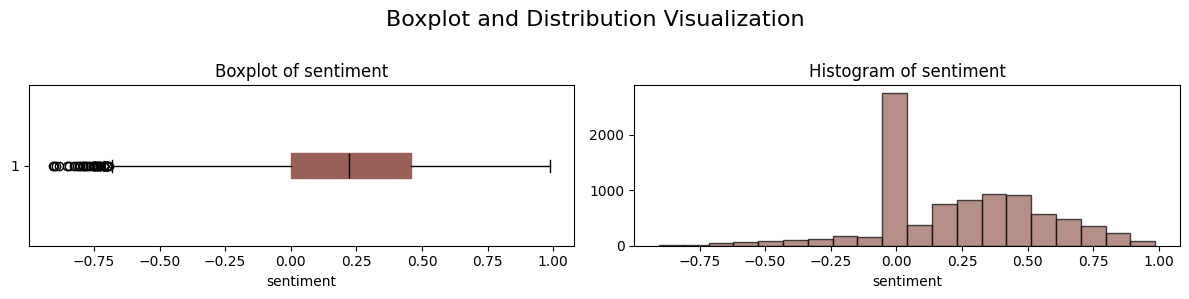

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

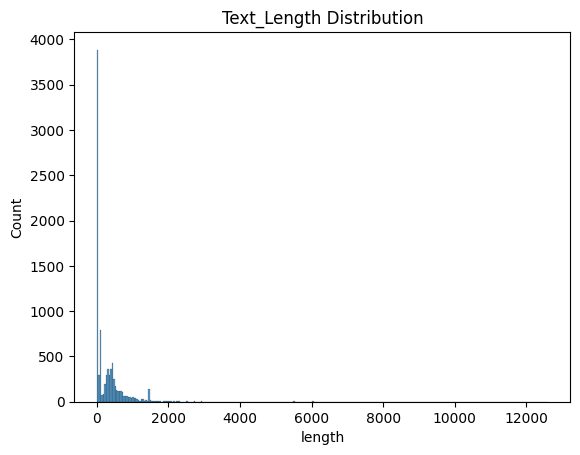

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count     9067.000000
mean       340.722510
std        789.960782
min          1.000000
25%          1.000000
50%         89.000000
75%        428.000000
max      12606.000000
Name: length, dtype: float64